In [1]:
# Imports
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read multiple excel sheets
excel_file = pd.ExcelFile('/content/drive/MyDrive/ggs692/GHGRP_data_2015_8_13_16.xlsx')

# Direct Emitters
direct_emitters = excel_file.parse('Direct Emitters')

# Make the row index 2 as columns
direct_emitters.columns = direct_emitters.iloc[2]
direct_emitters.drop([0,1, 2], axis=0, inplace=True)

# Read the second sheet
onshore_oil_gas_prod = excel_file.parse('Onshore Oil & Gas Prod.')

# LDC Direct Emissions
ldc_direct_emissions = excel_file.parse('LDC - Direct Emissions')

# SF6 from Elec. Equip
sfc_from_elec_equip = excel_file.parse('SF6 from Elec. Equip.')

# Suppliers
suppliers = excel_file.parse('Suppliers')

# CO2 injection
co_2_injection = excel_file.parse('CO2 Injection')

# Make the row index 2 as columns
co_2_injection.columns = co_2_injection.iloc[2]
co_2_injection.drop([0,1, 2], axis=0, inplace=True)

# Industry type
industry_type = excel_file.parse('Industry Type')

In [3]:
# AI generated fixes of state abbreviations
state_fix = {
    'Tx': 'TX', 'KY.': 'KY', 'KY ': 'KY', 'Nyork': 'NY', 'Nmex': 'NM', ' NM': 'NM', 'NMex': 'NM', 'il': 'IL',
    'NM ': 'NM', 'tx': 'TX', 'ala': 'AL', 'WI': 'WI', 'IL': 'IL', 'AR': 'AR', 'MO': 'MO', 'PA': 'PA', 'MI': 'MI',
    'WY': 'WY', 'FL': 'FL', 'NY': 'NY', 'TX': 'TX', 'IN': 'IN', 'Fl': 'FL', 'OH': 'OH', 'PR': 'PR', 'AL': 'AL',
    'SD': 'SD', 'NE': 'NE', 'KS': 'KS', 'MD': 'MD', 'IA': 'IA', 'LA': 'LA', 'TN': 'TN', 'GA': 'GA', 'Ga': 'GA',
    'CA': 'CA', 'HI': 'HI', 'OK': 'OK', 'KY': 'KY', 'ID': 'ID', 'WA': 'WA', 'Ca': 'CA', 'WV': 'WV', 'UT': 'UT',
    'ND': 'ND', 'AK': 'AK', 'NM': 'NM', 'CO': 'CO', 'VA': 'VA', 'NH': 'NH', 'NJ': 'NJ', 'MA': 'MA', 'MS': 'MS',
    'AZ': 'AZ', 'NV': 'NV', 'OR': 'OR', 'SC': 'SC', 'MT': 'MT', 'NC': 'NC', 'VT': 'VT', 'CT': 'CT', 'DE': 'DE',
    'RI': 'RI', 'ME': 'ME', 'DC': 'DC', 'VI': 'VI', 'GU': 'GU', 'TX.': 'TX', 'N.C.': 'NC', 'Cali': 'CA', 'Wi': 'WI',
    'S.C.': 'SC', ' GA': 'GA', 'OK ': 'OK', 'MS ': 'MS', ' UT': 'UT', 'LA ': 'LA', 'Ohio': 'OH', ' AL': 'AL',
    'AL ': 'AL', 'GA ': 'GA', ' FL': 'FL', ' MI ': 'MI', 'MI ': 'MI', 'Utah': 'UT', 'TX ': 'TX', 'SC ': 'SC',
    'OH ': 'OH', 'CO ': 'CO', 'CT.': 'CT', 'Co': 'CO', 'CALIFORNIA': 'CA', ' AR': 'AR', 'AR ': 'AR', 'cali': 'CA',
    'california': 'CA', 'California': 'CA', ' AZ': 'AZ', 'PA ': 'PA', 'IL ': 'IL', ' NC': 'NC'
}

In [4]:
# Fix the state abbreviations and naming convention
direct_emitters["STABBR"] = direct_emitters['State'].map(state_fix)
direct_emitters["STABBR"]

3       TX
4       KY
5       KY
6       NY
7       NM
        ..
7199    MI
7200    TX
7201    IL
7202    CO
7203    NC
Name: STABBR, Length: 7201, dtype: object

In [5]:
# Check for the max and min longitudes of the data
direct_emitters.Longitude.min(), direct_emitters.Latitude.max()

(-94361896, 44789444)

In [6]:
# Convert lat long to float, else nan and drop

direct_emitters['Latitude'] = pd.to_numeric(direct_emitters['Latitude'], errors='coerce')
direct_emitters['Longitude'] = pd.to_numeric(direct_emitters['Longitude'], errors='coerce')
direct_emitters = direct_emitters.dropna(subset=['Latitude', 'Longitude'])

In [7]:
# US bounding long and lat (AI generated)
us_bounding_box = {
    'mainland': {
        'north': 49.384358,  # Northern border with Canada
        'south': 24.396308,  # Southern tip of the Florida Keys
        'east': -66.93457,   # Easternmost point of Maine
        'west': -125.00165   # Westernmost point of Washington State
    },
    'alaska': {
        'north': 71.5388001,  # Northernmost point of Alaska
        'south': 51.214183,   # Southernmost point of the Aleutian Islands
        'east': -129.979511,  # Easternmost point of Alaska
        'west': -179.148909   # Westernmost point in the Aleutian Islands
    },
    'hawaii': {
        'north': 22.23559,    # Northernmost point of Kauai
        'south': 18.911306,   # Southernmost point of the Big Island
        'east': -154.806773,  # Easternmost point of Hawaii
        'west': -178.338813   # Westernmost point of Kure Atoll
    },
    'territories': {
        'guam': {
            'north': 13.654402,  # Northernmost point of Guam
            'south': 13.234189,  # Southernmost point of Guam
            'east': 144.952311,  # Easternmost point of Guam
            'west': 144.618068   # Westernmost point of Guam
        },
        'puerto_rico': {
            'north': 18.515978,  # Northernmost point of Puerto Rico
            'south': 17.926405,  # Southernmost point of Puerto Rico
            'east': -65.242737,  # Easternmost point of Puerto Rico
            'west': -67.271492   # Westernmost point of Puerto Rico
        },
        'american_samoa': {
            'north': -11.0497,   # Northernmost point of American Samoa
            'south': -14.382478, # Southernmost point of American Samoa
            'east': -169.418256, # Easternmost point of American Samoa
            'west': -171.141898  # Westernmost point of American Samoa
        },
        'northern_mariana_islands': {
            'north': 20.55344,   # Northernmost point of the Northern Mariana Islands
            'south': 14.110472,  # Southernmost point of the Northern Mariana Islands
            'east': 146.06528,   # Easternmost point of the Northern Mariana Islands
            'west': 144.896111   # Westernmost point of the Northern Mariana Islands
        },
        'us_virgin_islands': {
            'north': 18.415382,  # Northernmost point of the US Virgin Islands
            'south': 17.673931,  # Southernmost point of the US Virgin Islands
            'east': -64.560414,  # Easternmost point of the US Virgin Islands
            'west': -65.101333   # Westernmost point of the US Virgin Islands
        }
    }
}

In [8]:
def filter_data_by_bounding_box(df, bounding_boxes):
    """
    Filters a DataFrame based on multiple bounding boxes, including the mainland and non-contiguous states and territories.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        bounding_boxes (dict): A dictionary of dictionaries, each containing the bounding box coordinates for different parts of the US.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    # Initialize an empty DataFrame to store filtered data
    filtered_dfs = []

    # Iterate through each bounding box and append the filtered data
    for key, box in bounding_boxes.items():
        if isinstance(box, dict) and 'north' in box and 'south' in box:
            filtered_dfs.append(df[
                (df['Latitude'] >= box['south']) &
                (df['Latitude'] <= box['north']) &
                (df['Longitude'] >= box['west']) &
                (df['Longitude'] <= box['east'])
            ])
        elif isinstance(box, dict):

            # Recursive call for nested dictionaries (e.g., territories)
            filtered_dfs.append(filter_data_by_bounding_box(df, box))

    filtered_df = pd.concat(filtered_dfs)

    return filtered_df.drop_duplicates()

# Prepare a comprehensive bounding_boxes dictionary including mainland, Alaska, Hawaii, and territories
bounding_boxes = {
    'mainland': us_bounding_box['mainland'],
    'alaska': us_bounding_box['alaska'],
    'hawaii': us_bounding_box['hawaii'],
    'territories': us_bounding_box['territories']
}

# Filter the DataFrame using the comprehensive US bounding boxes
filtered_df = filter_data_by_bounding_box(direct_emitters, bounding_boxes)

# Remove the data where emissions are negative
new_filtered_df = filtered_df[filtered_df["Total reported direct emissions"] > 0]

# Check the shape of the filtered DataFrame
new_filtered_df.shape

(7068, 67)

In [9]:
# Get the removed data from previous df
removed_df = direct_emitters.drop(filtered_df.index)
print(removed_df.shape)

(15, 67)


There ar 15 rows of data outside of the US and territorial states

In [10]:
useful_cols = new_filtered_df[[
       'Total reported direct emissions', 'CO2 emissions (non-biogenic) ',
       'Methane (CH4) emissions ', 'Nitrous Oxide (N2O) emissions ',
       'HFC emissions', 'PFC emissions', 'SF6 emissions ', 'NF3 emissions',
       'Other Fully Fluorinated GHG emissions', 'HFE emissions',
       'Very Short-lived Compounds emissions', 'Other GHGs (metric tons CO2e)',
       'Biogenic CO2 emissions (metric tons)']].fillna(0)

df_head = new_filtered_df[['Facility Id', 'FRS Id', 'Facility Name', 'City', 'STABBR', 'Zip Code',
       'Address', 'County', 'Latitude', 'Longitude', 'Primary NAICS Code',
       'Industry Type (subparts)', 'Industry Type (sectors)']]

df_emissions = pd.concat([df_head, useful_cols], axis=1)

In [11]:
df_emissions.rename(columns={"STABBR": "State"}, inplace=True)

In [16]:
df_emissions.State.unique()

array(['KY', 'NY', 'NM', 'IL', 'TX', 'AL', 'WI', 'AR', 'MO', 'PA', 'MI',
       'FL', 'IN', 'OH', 'SD', 'NE', 'KS', 'MD', 'IA', 'LA', nan, 'TN',
       'GA', 'CA', 'OK', 'ID', 'WA', 'WV', 'UT', 'ND', 'CO', 'VA', 'NH',
       'NJ', 'MA', 'MS', 'WY', 'AZ', 'NV', 'OR', 'SC', 'MT', 'NC', 'VT',
       'CT', 'DE', 'RI', 'ME', 'DC', 'AK', 'HI', 'GU', 'PR', 'VI'],
      dtype=object)

In [17]:
# Export pandas dataframe to geojson
gdf = gpd.GeoDataFrame(df_emissions, geometry=gpd.points_from_xy(df_emissions.Longitude, df_emissions.Latitude))

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.crs = 'EPSG:4326'

<Axes: >

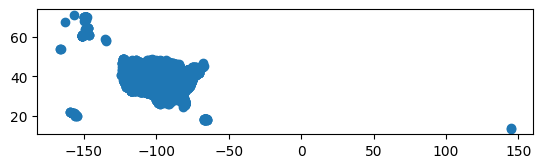

In [18]:
# Plot
gdf.plot()

In [19]:
# Save the data

gdf.to_file("/content/drive/MyDrive/ggs692/ghgrp_clean.geojson", driver="GeoJSON")

In [21]:
gdf.State.unique()

array(['KY', 'NY', 'NM', 'IL', 'TX', 'AL', 'WI', 'AR', 'MO', 'PA', 'MI',
       'FL', 'IN', 'OH', 'SD', 'NE', 'KS', 'MD', 'IA', 'LA', nan, 'TN',
       'GA', 'CA', 'OK', 'ID', 'WA', 'WV', 'UT', 'ND', 'CO', 'VA', 'NH',
       'NJ', 'MA', 'MS', 'WY', 'AZ', 'NV', 'OR', 'SC', 'MT', 'NC', 'VT',
       'CT', 'DE', 'RI', 'ME', 'DC', 'AK', 'HI', 'GU', 'PR', 'VI'],
      dtype=object)

<Axes: xlabel='Latitude', ylabel='Count'>

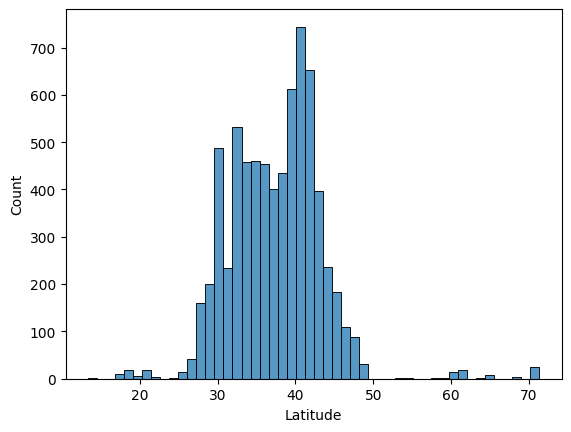

In [ ]:
sns.histplot(data=df_emissions, x="Latitude", bins=50)

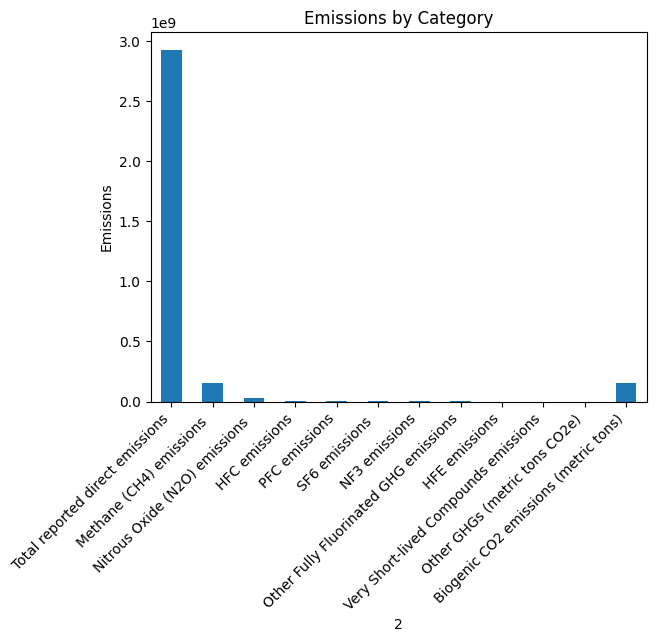

In [ ]:
emission_sums = useful_cols.sum(numeric_only=True)

# Plotting
emission_sums.plot(kind='bar')
plt.ylabel('Emissions')
plt.title('Emissions by Category')
plt.xticks(rotation=45, ha='right')
plt.show()